# Convolutional Neural Networks in Searching for EBs in TESS
-Te Han

In this project, we use Convolutional Neural Networks (CNN) to search for eclipsing binaries in TESS data. The primary methods are based on the two papers and one program from Kyle A. Pearson.

[1] Kyle A. Pearson, Leon Palafox, and Caitlin A. Griffith. "Searching for Exoplanets using Artificial Intelligence." 2018, MNRAS, 474, 478

[2] Kyle A. Pearson. "A search for multi-planet systems with TESS using a Bayesian N-body retrieval and machine learning."

[3] Github for both projects above. https://github.com/pearsonkyle/Exoplanet-Artificial-Intelligence

The author compares multiple deep learning logrithms as well as basic least-square box fitting in searching for exoplanets based on the light curve and concludes that CNN performs relatively good. Using Exoplanet Light Curve Analysis (ELCA), the author trains the CNN with transit with various sizes and contradicts with non-transits light curves. Based on the CNN network architecture the author build, I use batman package to produce EB light curves. With various training parameters, CNN has performed well in searching for EB in TESS data.

# Section 1: CNN architecture

This part copies Pearson's code for the CNN architecture.

In [2]:
import os
import pickle
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tensorflow.keras.layers import Input, Dense, Conv1D, AveragePooling1D, Concatenate, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

def pn_rates(model,X,y):
    y_pred = np.round( model.predict(X) )

    pos_idx = y==1
    neg_idx = y==0

    tp = np.sum(y_pred[pos_idx]==1)/y_pred.shape[0]
    fn = np.sum(y_pred[pos_idx]==0)/y_pred.shape[0]

    tn = np.sum(y_pred[neg_idx]==0)/y_pred.shape[0]
    fp = np.sum(y_pred[neg_idx]==1)/y_pred.shape[0]

    return fn,fp

def make_cnn(maxlen):
    
    input_local = Input(shape=(maxlen,1))
    x = Conv1D(16, 5, strides=1)(input_local)
    #x = Conv1D(16, 5, strides=1)(x)
    x = AveragePooling1D(pool_size=5, strides=2)(x)
    x = Conv1D(8, 5, strides=1)(x)
    #x = Conv1D(8, 5, strides=1)(x)
    x = AveragePooling1D(pool_size=5, strides=2)(x)
    
    xf = Flatten()(x)
    z = Dense(64, activation='relu')(xf)
    #z = Dropout(0.1)(z)
    z = Dense(32, activation='relu')(z)
    z = Dense(8, activation='relu')(z)

    output = Dense(1, activation='sigmoid', name='main_output')(z)
    model = Model(inputs=input_local, outputs=output)
    
    SGDsolver = SGD(lr=0.1, momentum=0.25, decay=0.0001, nesterov=True)
    model.compile(loss='binary_crossentropy',
                optimizer=SGDsolver,
                metrics=['accuracy'])
    return model

# Section 2: Training CNN


#### Batman requires 9 parameters:
1. orbital period
2. time of inferior conjunction
3. Time of secondary eclipse center.
4. planet radius (in units of stellar radii)
5. Planet-to-star flux ratio (for secondary eclipse models).
6. semi-major axis (in units of stellar radii)
7. orbital inclination (in degrees)
8. eccentricity
9. longitude of periastron (in degrees)

#### If we start with main sequence stars and circular orbits, we only have 5 parameters to randomize. 
1. r1
2. r2
3. a semimajor
4. t0 time of inferior conjunction
5. inc

#### with these we can get
1. Planet-to-star flux ratio (for secondary eclipse models)
2. orbital period
3. Time of secondary eclipse center.

#### and fixed values
1. ecc = 0
2. longitude of periastron (in degrees) = 90

Now we use batman to produce training data.

In [3]:
import batman
from astropy.io import ascii
from astropy.io import fits
import matplotlib.patches as mpatches
from astropy import constants as const

main_seq = ascii.read(r'mass_r_teff.dat')
mass = main_seq['M/Msun']
radius = main_seq['log10(r/cm)']
Teff = main_seq['log10(Teff/K)']
Sample_number = 500


def EB(number_of_samples,n_period):            
    positive = []
    for i in range(number_of_samples):
        #fixed
        params = batman.TransitParams()       #object to store transit parameters        
        params.ecc = 0.                       #eccentricity
        params.w = 90.                        #longitude of periastron (in degrees)
        params.limb_dark = 'quadratic'        #limb darkening model
        params.u = [0.1, 0.3]                 #limb darkening coefficients [u1, u2]
        
        #randomize
        n1 = np.random.randint(1, high = len(mass))
        n2 = np.random.randint(n1)
        r1 = 10 ** radius[n1]
        r2 = 10 ** radius[n2] 
        T1 = 10 ** Teff[n1]
        T2 = 10 ** Teff[n2] 
        m1 = mass[n1]
        m2 = mass[n2] 
        params.a = np.random.rand() * 10 + 1       #semi-major axis (in units of stellar radii)
        params.inc = 90. + np.random.randn() * 10  #orbital inclination (in degrees)
        
        # calculated based on previous parameters
        params.fp = (r2 ** 2 * T2 ** 4) / (r1 ** 2 * T1 ** 4)            #Planet-to-star flux ratio (for secondary eclipse models).
        params.per = (4 * np.pi **2 * (params.a * r1 * 1e-2) ** 3 
                      /(const.G.value * const.M_sun.value * (m1 + m2))) ** 0.5 / (24*3600)      #orbital period
        params.rp = r2 / r1                                              #planet radius (in units of stellar radii)
        params.t0 = 0.5 * params.per * n_period                          #time of inferior conjunction
        params.t_secondary = params.t0 - params.per/2                    #Time of secondary eclipse center. 
        
        #sampled time 
        t = np.linspace(0, n_period*params.per, Sample_number)
        
        #initializes model
        m = batman.TransitModel(params, t, transittype = 'primary')     
        flux_1 = m.light_curve(params)
        m = batman.TransitModel(params, t, transittype = 'secondary') 
        flux_2 = m.light_curve(params)
    
        #eliminate flat light curves due to high inclination
        flux = (flux_1 + flux_2) 
        if (np.max(flux) == np.min(flux)):
            params.inc = 90.
            m = batman.TransitModel(params, t, transittype = 'primary') 
            flux_1 = m.light_curve(params)
            m = batman.TransitModel(params, t, transittype = 'secondary')  
            flux_2 = m.light_curve(params)
            flux = (flux_1 + flux_2)
            flux /= (np.max(flux) - np.min(flux)) / 4     #4 is just a normalization factor that is used on all lc
            flux -= np.average(flux)+ 0.1 * np.random.randn(len(flux_1))
        else:
            flux /= (np.max(flux) - np.min(flux)) / 4
            flux -= np.average(flux)+ 0.1 * np.random.randn(len(flux_1))
        positive.append(flux)
    return positive

def non_EB(number_of_samples):            
    negative = []
    for i in range(number_of_samples):
        #fixed
        params = batman.TransitParams()       #object to store transit parameters
        params.ecc = 0.                       #eccentricity
        params.w = 90.                        #longitude of periastron (in degrees)
        params.limb_dark = 'quadratic'        #limb darkening model
        params.u = [0.1, 0.3]                 #limb darkening coefficients [u1, u2, u3, u4]
        
        #randomize
        n1 = np.random.randint(1, high = len(mass))
        n2 = np.random.randint(n1)
        r1 = 10 ** radius[n1]
        r2 = 10 ** radius[n2] 
        T1 = 10 ** Teff[n1]
        m1 = mass[n1]
        m2 = mass[n2] 
        params.a = np.random.rand() * 10 + 1       #semi-major axis (in units of stellar radii)
        params.inc = 90. + np.random.randn() * 25  #orbital inclination (in degrees)        
        
        # calculated based on previous parameters
        params.per = (4 * np.pi **2 * (params.a * r1 * 1e-2) ** 3 
                      /(const.G.value * const.M_sun.value * (m1 + m2))) ** 0.5 / (24*3600)      #orbital period
        params.rp = r2 / r1                        #planet radius (in units of stellar radii)
        params.t0 = 0.5 * params.per               #time of inferior conjunction
        
        #sampled time 
        t = np.linspace(0, params.per, Sample_number)
        
        #initializes model
        m = batman.TransitModel(params, t, transittype = 'primary')    
        flux_1 = m.light_curve(params)
    
        #add noise to flux
        if (np.max(flux_1) == np.min(flux_1)):
            flux = 1 * np.random.randn(len(flux_1))
        else:
            flux = flux_1
            flux /= (np.max(flux_1) - np.min(flux_1)) / 4
            flux -= np.average(flux)+ 0.1 * np.random.randn(len(flux_1))
        negative.append(flux)
    return negative

In [5]:
positive = EB(100000,1)
negative1 = non_EB(30000)
negative2 = EB(10000,1.3)
negative3 = EB(10000,1.6)
negative4 = EB(10000,2)
negative5 = EB(10000,3)
negative6 = EB(10000,4)
negative7 = EB(10000,5)
negative8 = EB(10000,6)

X = np.vstack([positive, negative1,negative2,negative3, negative4,negative5,negative6,negative7, negative8])
X = X.reshape((X.shape[0], X.shape[1], 1))
y = np.hstack([np.ones(len(positive)), np.zeros(len(positive))])

Text(-100, -1, 'Negative')

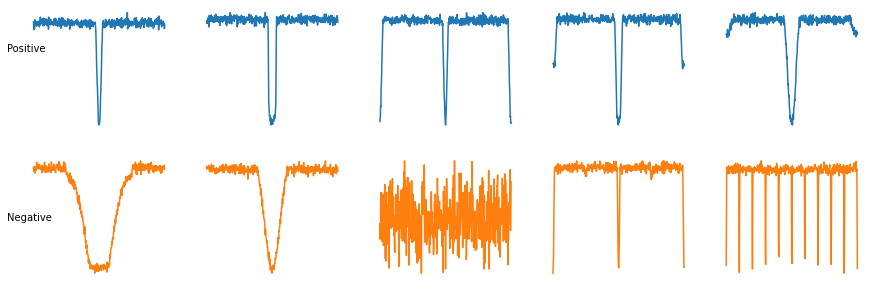

In [14]:
fig, axs = plt.subplots(2,5, figsize=(15, 5), facecolor='w', edgecolor='k')
axs = axs.ravel()
for j in range(5):
    axs[j].plot(X[j,:,0])
    axs[j].axis('off')

axs[5].plot(X[120000,:,0],'C1')
axs[5].axis('off')
axs[6].plot(X[120004,:,0],'C1')
axs[6].axis('off')
axs[7].plot(X[128004,:,0],'C1')
axs[7].axis('off')
axs[8].plot(X[158001,:,0],'C1')
axs[8].axis('off')
axs[9].plot(X[181000,:,0],'C1')
axs[9].axis('off')

axs[0].text(-100,-1,'Positive')
axs[5].text(-100,-1,'Negative')

We generate 100000 positive samples and 100000 negative samples. The first row shows 5 positive examples, and the second row shows two planetary transit, a noise, and two multiple periods samples. Adding more negative samples that have similar shapes with the positive ones improves the accuracy of the CNN when it predicts a new light curve. 

In [5]:
nb_epoch = 20
batch_size = 100
cnn = make_cnn(Sample_number)
history = cnn.fit(X, y, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_split=0.0, validation_data=None)

cnn.save_weights('tess_cnn.h5')

score = cnn.evaluate(X, y, verbose=1)
fn,fp = pn_rates(cnn,X,y)
print('\nTrain loss:', score[0])
print('Train accuracy:', score[1])
print('Train FP:',fp)
print('Train FN:',fn)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/20
200000/200000 [==============================] - 20s 99us/sample - loss: 0.2435 - acc: 0.8889
Epoch 2/20
200000/200000 [==============================] - 18s 89us/sample - loss: 0.1162 - acc: 0.9483
Epoch 3/20
200000/200000 [==============================] - 17s 87us/sample - loss: 0.0831 - acc: 0.9635
Epoch 4/20
200000/200000 [==============================] - 17s 85us/sample - loss: 0.0724 - acc: 0.9682
Epoch 5/20
200000/200000 [==============================] - 18s 91us/sample - loss: 0.0658 - acc: 0.9713
Epoch 6/20
200000/200000 [==============================] - 18s 88us/sample - loss: 0.0634 - acc: 0.9723
Epoch 7/20
200000/200000 [==============================] - 17s 87us/sample - loss: 0.0594 - acc: 0.9739
Epoch 8/20
200000/200000 [===========================

Now the model is trained. The Train accuracy is 0.97929 in this run, and the parameters are saved in 'tess_cnn.h5' to be used in searching for EB in TESS.

# Section 3: Testing CNN

We first examine its accuracy on never seen pseudo light curves.

In [6]:
# Produce new pseudo light curves
positive = EB(10000,1)
negative1 = non_EB(5000)
negative2 = EB(3000,2)
negative3 = EB(2000,3)
Xt = np.vstack([positive,negative1,negative2,negative3])
Xt = Xt.reshape((Xt.shape[0], Xt.shape[1], 1))
yt = np.hstack([np.ones(len(positive)), np.zeros(len(positive))])

score = cnn.evaluate(Xt, yt, verbose=1)
fn,fp = pn_rates(cnn,Xt,yt)
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])
print('Test FP:',fp)
print('Test FN:',fn)

20000/20000 [==============================] - 1s 55us/sample - loss: 0.0583 - acc: 0.9738

Test loss: 0.05829351917449662
Test accuracy: 0.9738
Test FP: 0.0191
Test FN: 0.0071


Text(-100, 0, 'Negative')

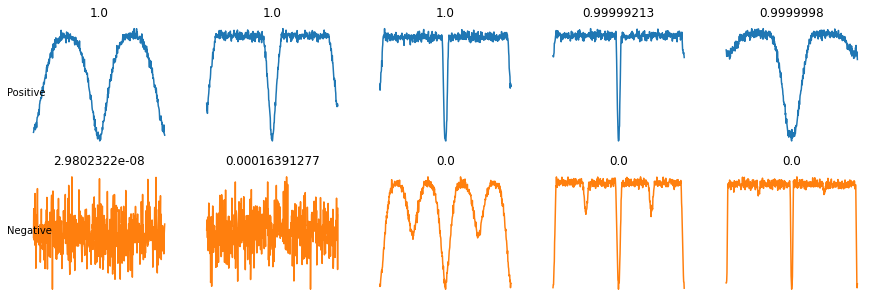

In [7]:
y_pos = cnn.predict(Xt[:10000])
y_neg = cnn.predict(Xt[10000:])

fig, axs = plt.subplots(2,5, figsize=(15, 5), facecolor='w', edgecolor='k')
axs = axs.ravel()
for j in range(5):
    axs[j].plot(Xt[j+10,:,0])
    axs[j].set_title(y_pos[j+10,0])
    axs[j].axis('off')
for j in range(5):
    axs[j+5].plot(Xt[j+14998,:,0],'C1')
    axs[j+5].set_title(y_neg[j+4998,0])
    axs[j+5].axis('off')
axs[0].text(-100,-1,'Positive')
axs[5].text(-100,0,'Negative')

Some of the testing light curves and their test results. 1 means CNN thinks it is likely to be an EB light curve, and 0 means CNN thinks it is unlikely to be one. The blue light curves are generated with EB model (ideally have a value near 1) and the orange ones are generated as other models (ideally have a value near 0). 

For the blue (positive model) lc's, we can see that CNN performs good on those with deep secondary eclipse and is suspicious on the shallower ones. This is understandable because those lc's look more like planetary transits, which are given to CNN as negative training samples. 

For the orange (negative model) lc's, CNN is very certain about these 5 examples as non-EBs. 

Now, we "teached" CNN to recognize light curves with primary eclipse (time of mid-eclipse) at the center, secondary eclipse presented, and single-phased light curves. We should test our model on real TESS data, which may have much more uncertainties and unexpected light curves. This section (Section 4) is in another Jupyter notebook in "Searching EBs in TESS using trained CNN".  